In [1]:
import cv2
import json
import numpy as np
from sympy.geometry import Point,Circle,Segment,intersection,Line
import matplotlib.pyplot as plt
from matplotlib.patches import Arc as Arc_patch
from matplotlib import collections  as mc
from IPython.display import clear_output

In [2]:
class Arc:
    def __init__(self,r,theta1,theta2,origin = (0,0)):
        x,y = origin
        self.x = x
        self.y = y
        self.r = r
        self.origin = origin
        self.theta1 = theta1
        self.theta2 = theta2
        self.circle = Circle(Point(x,y),r)        
        self.endpoints = [Point(self.x+r*np.cos(theta1),self.y+r*np.sin(theta1)),Point(self.x+r*np.cos(theta2),self.y+r*np.sin(theta2))]
    
    def __contains__(self,point):
        xp,yp = float(point.x)-self.x,float(point.y)-self.y
        rot = np.array([[np.cos(self.theta1),-1*np.sin(self.theta1)],
                        [np.sin(self.theta1),np.cos(self.theta1)]])
        xp,yp = np.array([xp,yp]) @ rot
        theta = np.arctan2(yp,xp) if (yp>=0 or (self.theta1<=0 and self.theta2>=0) or (self.theta2<=0 and self.theta1>=0)) else 2*np.pi + np.arctan2(yp,xp)
        return (theta>=0 and theta<=self.theta2-self.theta1) or (theta>=self.theta2-self.theta1 and theta<=0)

    def draw(self,ax,color):
        ax.add_patch(Arc_patch((self.x, self.y), 2*self.r,2*self.r, theta1=np.rad2deg(self.theta1), theta2=np.rad2deg(self.theta2), linewidth=1, color=color))       

#intersections
def arc_arc(gamma2,gamma2prime):
    eta,etaprime = gamma2.circle,gamma2prime.circle
    intersect = intersection(eta,etaprime)
    pts = []
    if len(intersect) > 0:
        if intersect[0] in gamma2 and intersect[0] in gamma2prime:
            pts.append(intersect[0])
    if len(intersect) > 1:
        if intersect[1] in gamma2 and intersect[1] in gamma2prime:
            pts.append(intersect[1])    
        
    return pts

def line_line(l1,l2):
    return intersection(l1,l2)

def line_arc(l1prime,gamma2):
    intersect = intersection(l1prime,gamma2.circle)
    pts = []
    if len(intersect)>0:
        if intersect[0] in gamma2:
            pts.append(intersect[0])
    if len(intersect)>1:
        if intersect[1] in gamma2:
            pts.append(intersect[1]) 
    return pts        
       
    

class Interval:
    """
    Defined by r1,r2,theta1,theta2 and the origin.
    r1<r2 and theta1<theta2
    """
    def __init__(self,r1,r2,theta1,theta2,origin=(0,0)):

        not_zero = lambda x: x if x != 0.0 else 1e-6    
        r1,r2,theta1,theta2 =  list(map(not_zero,[r1,r2,theta1,theta2])) 
        delta = abs(theta2-theta1)
        theta2 = max(theta1,theta2)
        theta2 = theta2%(2*np.pi)
        theta1 = theta2 - delta   
         
        
        self.r1 = r1
        self.r2 = r2  
        self.theta1 = theta1
        self.theta2 = theta2
        #print("self.theta2 = ",self.theta2)
        x,y = origin
        self.origin = origin
        self.x = x
        self.y = y
        self.gamma1 = Arc(r1,theta1,theta2,origin=origin)
        self.gamma2 = Arc(r2,theta1,theta2,origin=origin)
        self.l1 = Segment((x+r1*np.cos(theta1),y+r1*np.sin(theta1)),(x+r2*np.cos(theta1),y+r2*np.sin(theta1)))
        self.l2 = Segment((x+r1*np.cos(theta2),y+r1*np.sin(theta2)),(x+r2*np.cos(theta2),y+r2*np.sin(theta2)))
        self.l = [self.l1,self.l2]
        self.gamma = [self.gamma1,self.gamma2]    

    def __contains__(self,point):
        r = np.linalg.norm(np.array([float(point.x),float(point.y)])-np.array(self.origin))
        return (r<=self.r2 and r>=self.r1) and (point in self.gamma1)    
    
    def __repr__(self):
        return f"Interval({self.r1},{self.r2},{self.theta1},{self.theta2},{self.origin})"
    
    def draw(self,ax,color):
        try:
            l11, l12 = tuple(self.l1.points[0]),tuple(self.l1.points[1])
            l21, l22 = tuple(self.l2.points[0]),tuple(self.l2.points[1])
            lc = mc.LineCollection([[l11,l12],[l21,l22]], colors = color, linewidths=1)
            self.gamma1.draw(ax,color)
            self.gamma2.draw(ax,color)
            ax.add_collection(lc) 
            
        except AttributeError:
            self.gamma1.draw(ax,color)
            self.gamma2.draw(ax,color)
    
    def fast_analysis(self,Iprime):
        I = self
        test_pts = []
        O = Point(I.origin)
        D = np.linalg.norm(np.array(I.origin)-np.array(Iprime.origin))
        if D>I.r2 + Iprime.r2:
            return Interval(0,0,0,0,I.origin)



        for gmp in Iprime.gamma:
            for gmi in I.gamma:
                pts = arc_arc(gmi,gmp)
                test_pts += pts    
            for li in I.l:
                pts = line_arc(li,gmp)
                test_pts += pts 
            if D<=I.r2 + Iprime.r2:
                normal_line = Line(I.origin,Iprime.origin)
                normal_points = gmp.circle.intersection(normal_line)
                for foot_normal in normal_points:
                    if foot_normal in gmp:
                        if foot_normal in I:
                            test_pts += [foot_normal]
            if D**2<=I.r2**2 + Iprime.r2**2:
                try:
                    for line in gmp.circle.tangent_lines(O):
                        if len(line.points)>1:
                            tangent_pt = line.points[1]
                            if tangent_pt in gmp:
                                if tangent_pt in I:
                                    test_pts += [tangent_pt]
                except IndexError:
                    pass
        for lp in Iprime.l:
            for gmi in I.gamma:
                pts = line_arc(lp,gmi)
                test_pts += pts    
            for li in I.l:
                test_pts += line_line(li,lp) 
            base_perpendicular = lp.perpendicular_segment(O).points[1]
            if lp.contains(base_perpendicular):
                if base_perpendicular in I:
                    test_pts += [base_perpendicular]    


        for point in Iprime.gamma2.endpoints+Iprime.gamma1.endpoints:
            if point in I:
                test_pts+= [point]
        if not test_pts:
            return Interval(0,0,0,0,I.origin)
        def cart2pol(pt):
            x,y = float(pt.x),float(pt.y)
            xi,yi = np.array([x,y])-np.array(I.origin)
            rho = np.linalg.norm(np.array([xi,yi]))
            phi = np.arctan2(yi,xi) if (yi>=0 or (I.theta1*I.theta2<=0)) else 2*np.pi + np.arctan2(yi,xi)
            return [rho, phi]
        rad_pts = np.array(list(map(cart2pol,test_pts)))
        R = rad_pts[:,0]
        THETA = rad_pts[:,1]
        rmax,rmin = max(R),min(R)
        thetamax,thetamin = max(THETA),min(THETA)
        return Interval(rmin,rmax,thetamin,thetamax,I.origin)

 
    def complement(self,J):
        if J.r2 == 1e-6 and J.theta1 - J.theta2 == 0:
            return [self]
        Is = []
        Jtheta2,Jtheta1 = J.theta2,J.theta1
        if self.theta1*self.theta2<0:
            if J.theta1>self.theta2:
                Jtheta2,Jtheta1 = J.theta2-2*np.pi,J.theta1-2*np.pi
        #now I.theta1<J.theta1<J.theta2<I.theta2        
                
        if abs(self.theta1 - Jtheta1)>1e-4 and abs(self.theta1 - Jtheta1)<np.pi-1e-4:
            I1 = Interval(self.r1,self.r2,self.theta1,Jtheta1,self.origin)
            Is.append(I1)

            
        if abs(Jtheta1 - Jtheta2)>1e-4:    
            I2 = Interval(self.r1,J.r1,Jtheta1,Jtheta2,self.origin)
            Is.append(I2)

        if abs(Jtheta2 - self.theta2)>1e-4 and abs(Jtheta2 - self.theta2)<np.pi-1e-4:    
            I3 = Interval(self.r1,self.r2,Jtheta2,self.theta2,self.origin)
            Is.append(I3)

        return Is

In [29]:
class Robot:
    radius = 18
    Δt = 1
    obstacles = [] # array with Interval objects

    
    def __init__(self,x_bot,y_bot,yaw,vi,vj,wi,wj,path):
        self.x_bot = x_bot
        self.y_bot = y_bot
        self.yaw = yaw
        self.vi = vi
        self.vj = vj
        self.wi = wi
        self.wj = wj
        self.color = 'blue'
        self.path = path
        self.fellows = []
        x,y,_ = self.path.T
        self.lookahead = 75
        self.tracker = PurePursuitTracker(x,y,(self.vi-self.vj)*0.75,lookahead=self.lookahead)
        self.tracker.revamp()
        self.trajectory = [[x_bot,y_bot]]
        self.done = False
    

        
    @property
    def interval(self):
        theta1 = self.yaw%(2*np.pi) - (self.wi - self.wj)*self.Δt
        theta2 = self.yaw%(2*np.pi) + (self.wi - self.wj)*self.Δt
        origin = (self.x_bot+self.radius*(np.cos(theta1)+np.cos(theta2))/(1e-6 + np.sin(theta1-theta2)),
                       self.y_bot+self.radius*(np.sin(theta1)+np.sin(theta2))/(1e-6 + np.sin(theta1-theta2)))

        n = self.radius/(1e-6+np.sin((theta2-theta1)/2))
        nu1 = n - self.radius
        nu2 = n + self.radius + (self.vi-self.vj)*self.Δt
        return Interval(nu1,nu2,theta1,theta2,origin)
        
    
    
    def __repr__(self):
        return f"Robot at {self.x_bot},{self.y_bot},{self.yaw}"
    
    
    def collision_detection(self):
        Js = []       
        I = self.interval
        for obstacle in self.obstacles:
            J = I.fast_analysis(obstacle)
            if not(J.r2 == 1e-6 and J.theta1 -J.theta2 == 0) :
                Js.append(J)
            del J 
        for fellow in self.fellows:
            J = I.fast_analysis(fellow.interval)
            if not(J.r2 == 1e-6 and J.theta1 -J.theta2 == 0) :
                Js.append(J)
            del J     
        return Js

    
    def generate_vw(self):
        min_angle = np.pi/24
        num_samples = np.ceil((abs(self.interval.theta2-self.interval.theta1)/min_angle)/2).astype('int')
        vws = []
        v = (self.interval.r2-self.interval.r1-2*self.radius)/self.Δt
        
        for i in range(num_samples):
            w = i*min_angle*self.Δt   
            vws.append([v,-1*w])
        for i in range(num_samples):
            w = i*min_angle*self.Δt
            vws.append([v,w])    
        return vws
            
    def collision_avoidance(self,Js,control,traj_v,traj_w,ax):
        """
        gives good v,w based on the inclusion region
        control = 0 for random
                  1 for maximum change
                  2 for least change
        """
        I = self.interval
        vws = self.generate_vw()

        min_angle = np.pi/24
        comps = set()
        wt = lambda vw: vw[0]+(self.vi-self.vj)*abs(vw[1]/(2*self.wi-2*self.wj))
        
        if not len(Js) == 0:
            
            
            for J in Js:
                if not (J.r2 < 1e-4 and abs(J.theta2-J.theta1) < 1e-6):
                    comps.update(I.complement(J))
     
            for comp in comps:
                #print(comp)
                comp.draw(ax,'magenta')
                if not(comp.theta2-I.theta2 or comp.theta1-I.theta1):
                    continue  
                else:   
                    for i,[v,w] in enumerate(vws):
                        if self.yaw%(2*np.pi)+w*self.Δt<= max(comp.theta1,comp.theta2)+np.arcsin(self.radius/(I.r2-self.radius))+2*np.pi/24 and \
                        self.yaw%(2*np.pi)+w*self.Δt>=min(comp.theta1,comp.theta2)-np.arcsin(self.radius/(I.r2-self.radius))-2*np.pi/24:
                            #np.pi/24 is min angle
                            vnew = ((comp.r2-comp.r1-2*self.radius)/self.Δt)
                            if v>vnew and vnew>=0:
                                vws[i][0] = vnew

            vwes = np.array(vws)
            #np.random.shuffle(vwes)
            is_collide = True
            
            for v,w in vwes:
                if abs(v-traj_v)<=abs(self.vi-self.vj)*0.05 and abs(w-traj_w)<np.pi/15:
                    v_max = v
                    ws = w
                    break 
            else:        
                if control == 2:
                    v_max,ws = vwes[np.argmin(wt(vwes-np.array([traj_v,traj_w])).T)]

                if control == 1:
                    #v_max,ws = vwes[np.argmax(vwes[:,0])]

                    v_max,ws = vwes[np.argmax(wt(vwes-np.array([traj_v,traj_w])).T)]
                if control == 0:
                    idx = np.random.choice(range(len(vwes)))
                    v_max,ws = vwes[idx]
                    v_max = 0.6*v_max        
            

                
            if max(vwes[:,0])<abs(self.vi-self.vj)*0.5:
                v_max = 0
                ws = abs(self.wi-self.wj)*np.sign(traj_w)*0.5
            vwn = np.array([v_max,ws])

        else:
            max_w = abs(self.wi-self.wj)
            traj_w = traj_w if abs(traj_w)<max_w else max_w*np.sign(traj_w)
            traj_v = traj_v if traj_v<=abs(self.vi-self.vj) else abs(self.vi-self.vj)
            vwn = np.array([traj_v,traj_w])
            is_collide = False
        
        return vwn,is_collide

    
    def next_bot(self,Js,control,ax,traj_v = None,traj_w = None):
        if not len(Js):
            return self.next_pose(Js,control,ax,traj_v = None,traj_w = None)
        if self.done:
            return self
        if traj_v is None and traj_w is None:
            traj_v,traj_w = self.tracker.v,self.tracker.w
#         Js = self.collision_detection()
        vw,is_collide = self.collision_avoidance(Js,control,traj_v,traj_w,ax)
        v,w = vw
        yaw = self.yaw + w*self.Δt
        x_bot = self.x_bot + v*np.cos(yaw)*self.Δt
        y_bot = self.y_bot + v*np.sin(yaw)*self.Δt
        self.yaw = yaw
        self.x_bot = x_bot
        self.y_bot = y_bot
        self.trajectory.append([x_bot,y_bot])
        if is_collide:
            self.tracker.revamp()
            
        if self.tracker.update(self.x_bot,self.y_bot,self.yaw): 
            print("ARRIVED!!") 
            self.done = True
            return self
        
        return self
    def next_pose(self,Js,control,ax,traj_v = None,traj_w = None):
        if self.done:
            return self
        if traj_v is None and traj_w is None:
            traj_v = self.tracker.v if self.tracker.v <= (self.vi-self.vj) else (self.vi-self.vj)
            traj_w = self.tracker.w if abs(self.tracker.w) <= self.wi-self.wj else (self.wi-self.wj)*np.sign(self.tracker.w)
#         Js = self.collision_detection()
#         vw,is_collide = self.collision_avoidance(Js,control,traj_v,traj_w,ax)
#         v,w = vw
        v,w = traj_v,traj_w
        yaw = self.yaw + w*self.Δt
        x_bot = self.x_bot + v*np.cos(yaw)*self.Δt
        y_bot = self.y_bot + v*np.sin(yaw)*self.Δt
        self.yaw = yaw
        self.x_bot = x_bot
        self.y_bot = y_bot
        self.trajectory.append([x_bot,y_bot])
#         if is_collide:
#             self.tracker.revamp(self.x_bot,self.y_bot)
            
        if self.tracker.update(self.x_bot,self.y_bot,self.yaw): 
            print("ARRIVED!!") 
            self.done = True
            return self
        
        return self
    
     
    def plot(self,ax):
        bot_circle = plt.Circle( (self.x_bot, self.y_bot),self.radius,color=self.color)
        arrow = ax.arrow(self.x_bot,self.y_bot,self.radius*np.cos(self.yaw),self.radius*np.sin(self.yaw))
        patch = ax.add_patch(bot_circle)
        traced = np.array(self.trajectory).T    
        if len(traced):
            ax.plot(traced[0],traced[1],f'{self.color[0]}-') 
        pathx = np.array(self.path).T    
        ax.plot(pathx[0],pathx[1],'y-')
        return [bot_circle,arrow]
                           
    def plot_interval(self,ax):
        self.interval.draw(ax,self.color)

    
    @classmethod
    def set_environment(cls,obstacles):
        cls.obstacles = obstacles
        
       

In [15]:
aa = np.array([[1,1],[2,2],[3,3],[-4,-1],[0.5,-0.2]])
bb = np.array([1,1])
aa[np.argmin(sum(aa.T))]

array([-4., -1.])

In [25]:
class PurePursuitTracker:
  
    def __init__(self, x, y, v, lookahead = 30):
        """
        Tracks the path defined by x, y at velocity v
        x and y must be numpy arrays
        v and lookahead are floats
        """
        self.length = len(x)
        self.ref_idx = 0 
        self.lookahead = lookahead
        self.x, self.y = x, y
        self.v, self.w = v, 0
        self.goal_threshold = 30

    def update(self, xc, yc, theta):
        """
        Input: xc, yc, theta - current pose of the robot
        Update v, w based on current pose
        Returns True if trajectory is over.
        """
        e = 1.2
        if self.ref_idx >= self.length:
            ref_x,ref_y = self.x[-1],self.y[-1]
        else:  
            ref_x,ref_y = self.x[self.ref_idx],self.y[self.ref_idx]
        
        if self.ref_idx > self.length and np.sqrt((ref_x-self.x[-1])**2+ (ref_y-self.y[-1])**2) < self.goal_threshold: 
            return True   
#         if np.sqrt((xc-self.x[-1])**2+ (yc-self.y[-1])**2) < self.goal_threshold:
#             return True
        
        if np.sqrt((ref_x-xc)**2+ (ref_y-yc)**2) < self.lookahead:
            self.ref_idx += 1 
        
        anchor = e*np.asarray([ref_x - xc, ref_y - yc])

        theta = np.pi/2 - theta
        rot = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        anchor = np.dot(rot, anchor)
        
        L = np.sqrt(anchor[0] ** 2 + anchor[1] **2) # dist to reference path
        
        X = anchor[0] 
        
        self.w = -2*self.v*X/L/L

        return False
    def revamp(self):
                
        self.x = self.x[self.ref_idx:]
        self.y = self.y[self.ref_idx:]
        self.ref_idx = 0
        self.length = len(self.x)
            
            

def get_line(start, end,sampling1,sampling2):
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
    
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    pts = []    
    for i in range(len(points)):
        if (i<len(points)*0.3 or i>len(points)*0.7) and i%sampling2 == 0:
            pts.append(points[i])
        elif i%sampling1 == 0 :
            pts.append(points[i])    
            
    slop = Segment(start,end).slope
    if slop is Segment((0,0),(0,1)).slope:
        s = np.arctan(float(slop)*(end[1]-start[1]))
    else:
        s = np.arctan(float(slop))
    thetas = s*np.ones((len(pts),1)) 
    poses = np.append(np.array(pts),thetas,axis=1)
    
    return poses

In [8]:
A = (250,800)
B = (200,100)
C = (660,250)
D = (800,600)
E = (400,1000)
AB = get_line(A,B)
BC = get_line(B,C)
CD = get_line(C,D)
DE = get_line(D,E)

ARRIVED!!


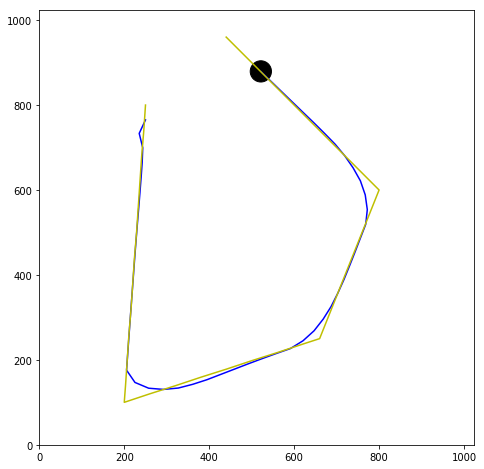

In [11]:
full = np.concatenate((AB,BC,CD,DE),axis=0)
#robot = Robot(*(A),4.7,20,0,0.8,0)

#robot = Robot(626.4324691367921, 248.21824382060316, 6.842399164334139-2*np.pi,40,0,1.13,0)
#robot = Robot(600,600, 2*np.pi+1,35,0,1.13,0)
robot = Robot(*A,3*np.pi/2,35,0,1.13,0)

#robot = Robot(*(250,600),3.14,20,0,1,0)


log = []

# fig,ax = plt.subplots(figsize=(8,8))
# ax. set_aspect('equal')
# ax.set_xlim([0, 1024])
# ax.set_ylim([0, 1024])
# ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
traj = []
path = full #AABB #PQ #np.array([[200,800-i*12,np.pi/2] for i in range(55)])
x,y,t = path.T
tracker = PurePursuitTracker(x,y,35,lookahead=130) 
pose = [robot.x_bot,robot.y_bot,robot.yaw] #arbitrary initial pose
# robot.plot(ax)
# robot.plot_interval(ax)
i = 0
while True:
    try:
        #print("v = ",tracker.v," w = ",tracker.w)

          
#         plt.clf()
        clear_output(wait = True)
        fig,ax = plt.subplots(figsize=(8,8))
        ax. set_aspect('equal')
        ax.set_xlim([0, 1024])
        ax.set_ylim([0, 1024])
        ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
        
        robot.plot(ax)
        traced = np.array(traj).T    
        if len(traced):
            ax.plot(traced[0],traced[1],'b-') 
        pathx = np.array(path).T    
        ax.plot(pathx[0],pathx[1],'y-')
        nex_bot,is_collide = robot.next_bot(tracker.v,tracker.w,ax)
        #nex_bot,is_collide = robot.next_pose(tracker.v,tracker.w),False
        pose = [robot.x_bot,robot.y_bot,robot.yaw]
        traj.append([*pose, tracker.w, tracker.ref_idx])
        
        log.append(f'run {i} :'+repr(pose))
        if is_collide or i==0:# or i%5==0:
            tracker.revamp(pose[0],pose[1])
            
        if tracker.update(*pose): 
            print("ARRIVED!!") 
        
            break
        plt.show() 
        robot = nex_bot
        i+=1
        print("run : ",i)
        
        if i == 150:
            break
    
        #plt.pause(0.5)    
    except KeyboardInterrupt:
        try:
            break
        except GeometryError:
            break
  

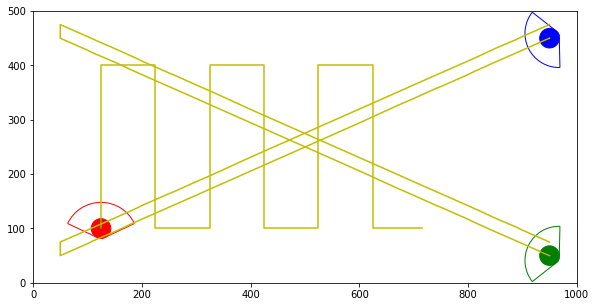

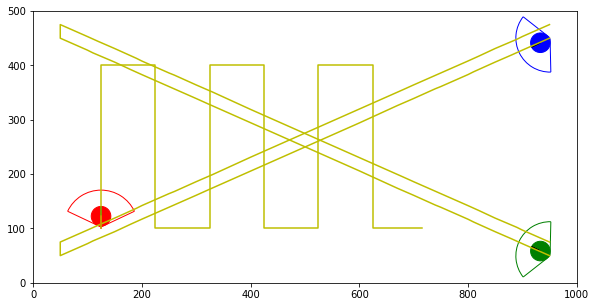

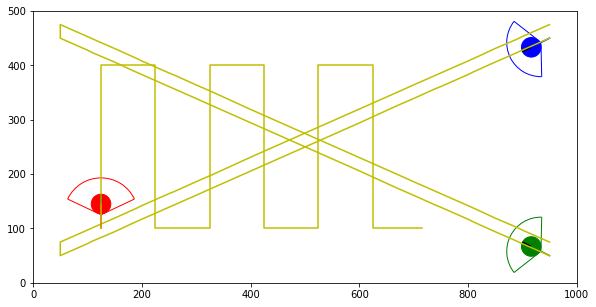

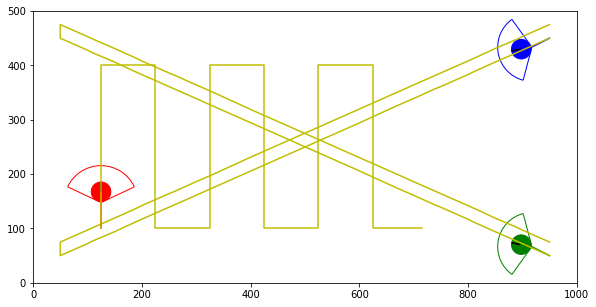

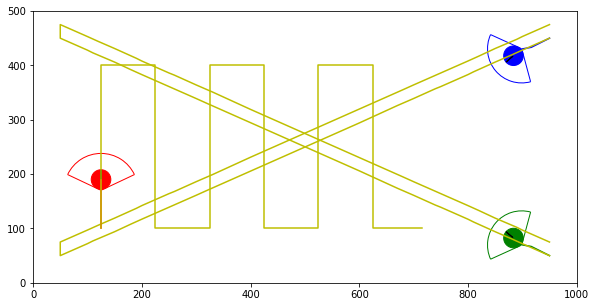

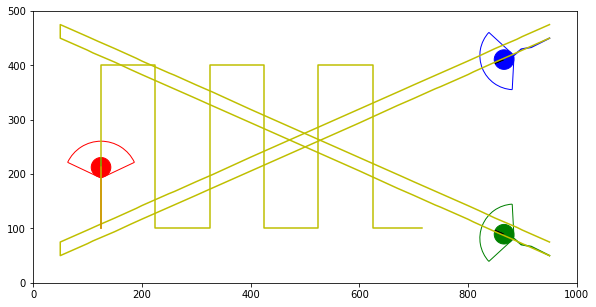

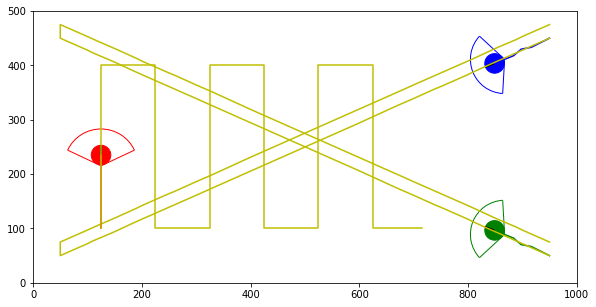

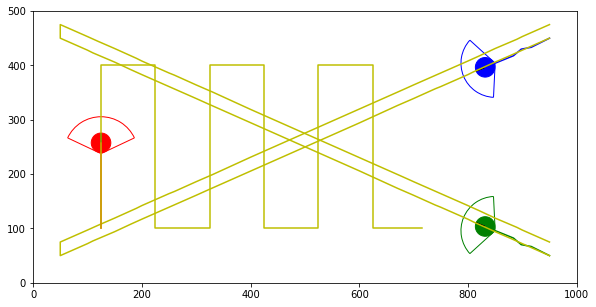

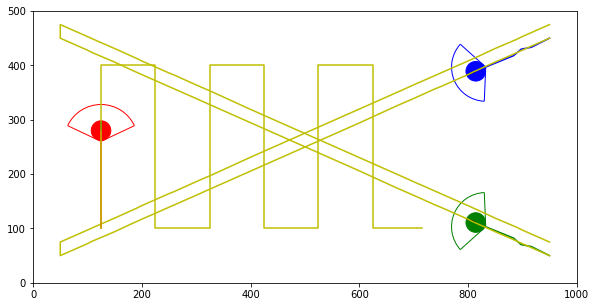

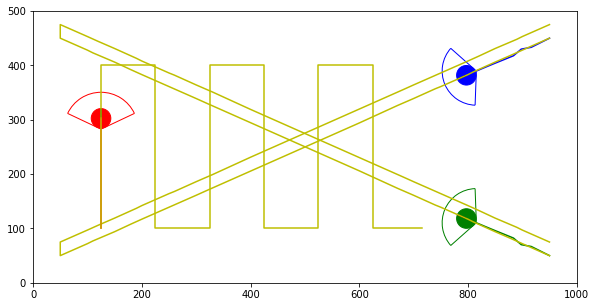

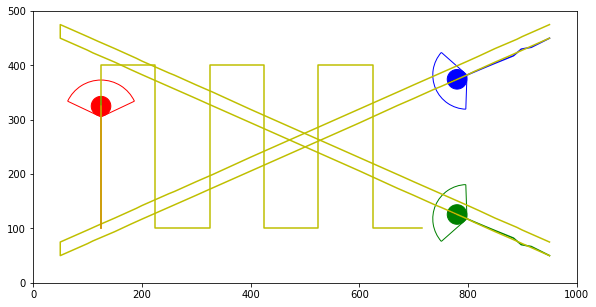

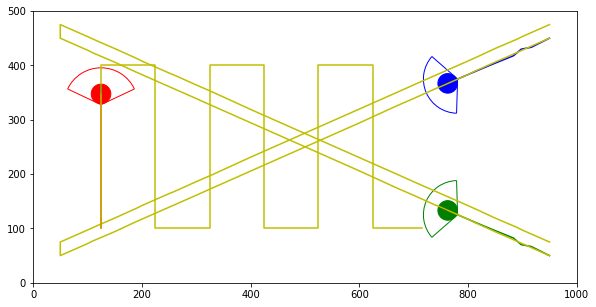

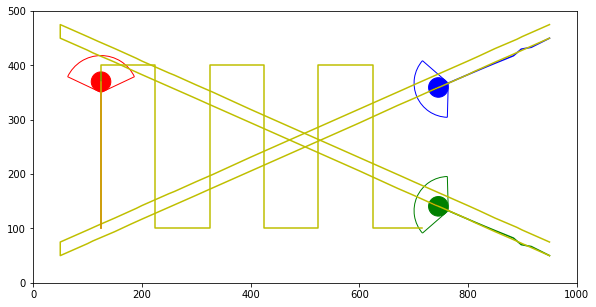

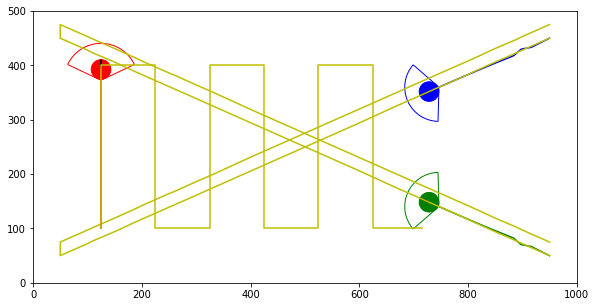

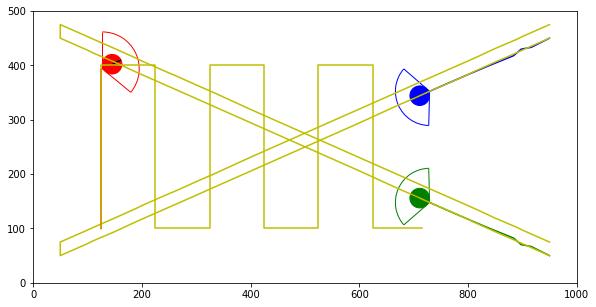

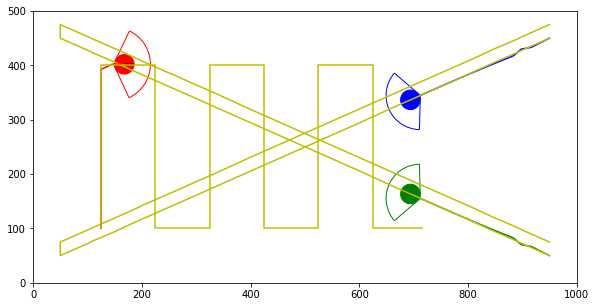

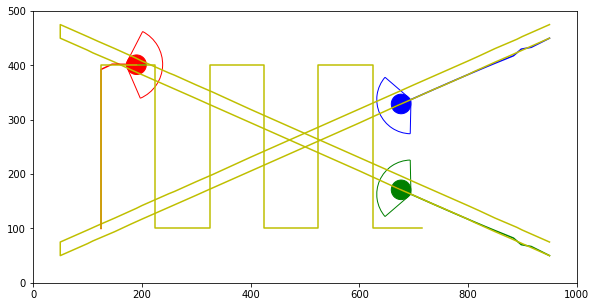

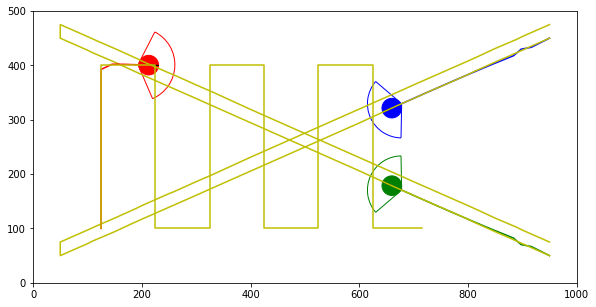

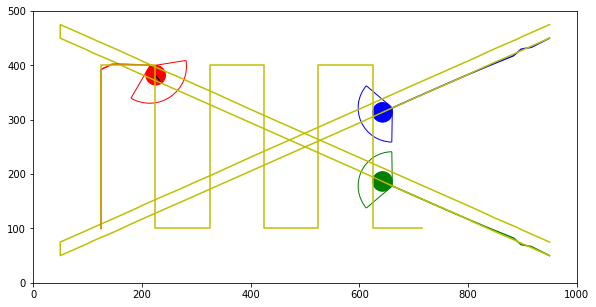

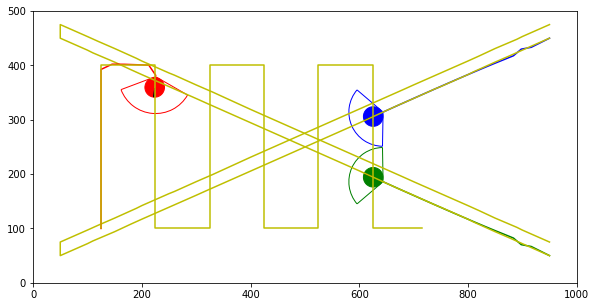

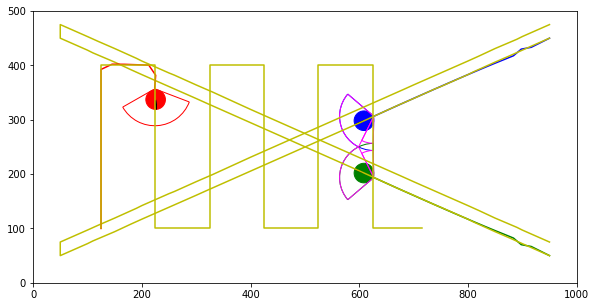

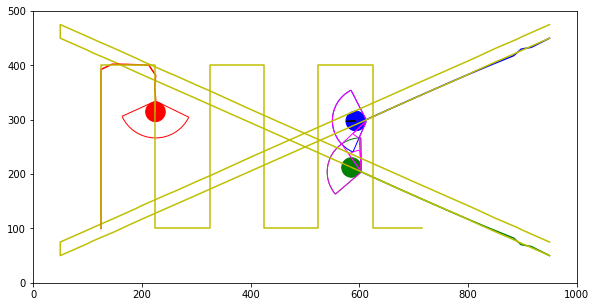

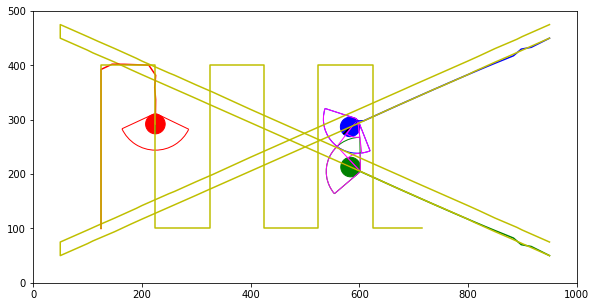

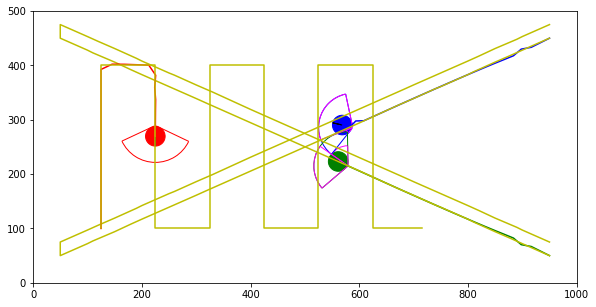

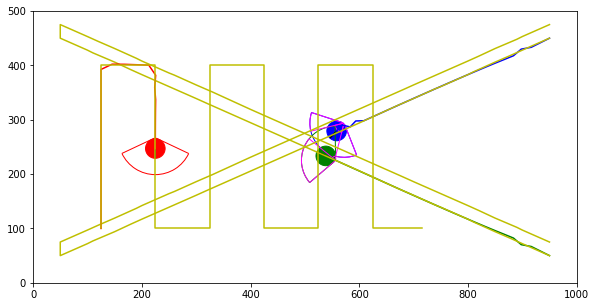

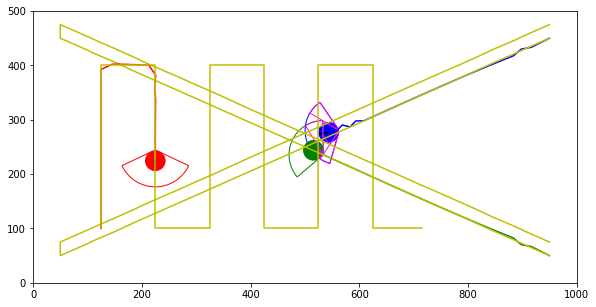

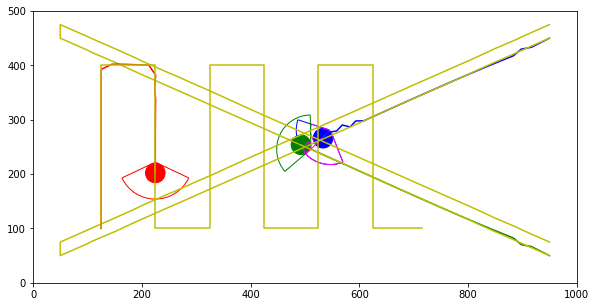

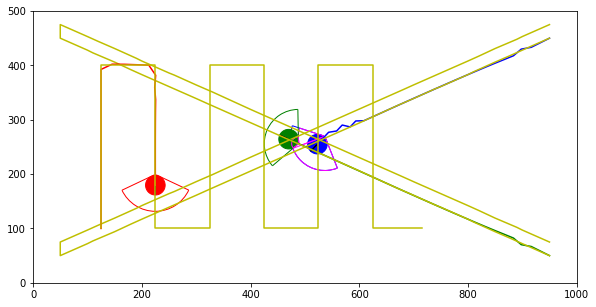

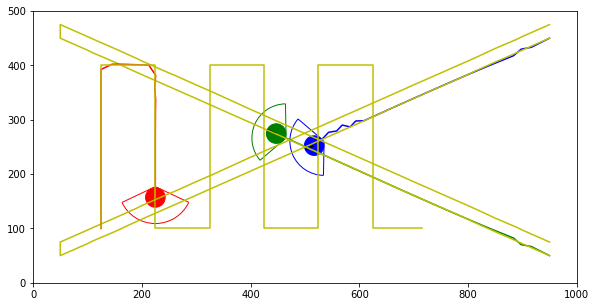

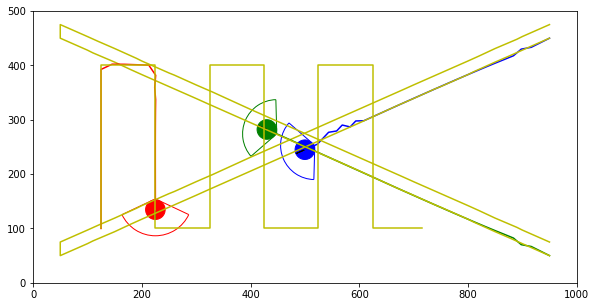

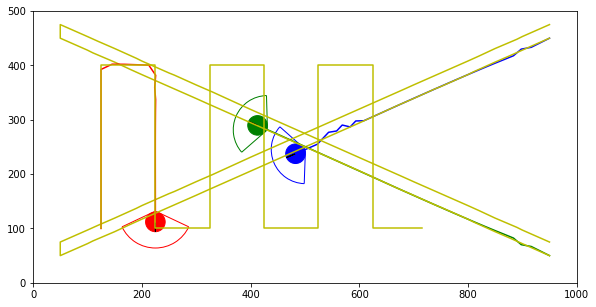

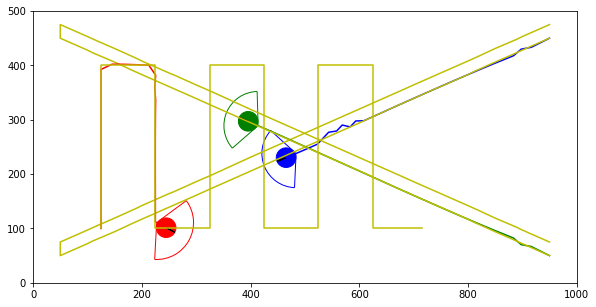

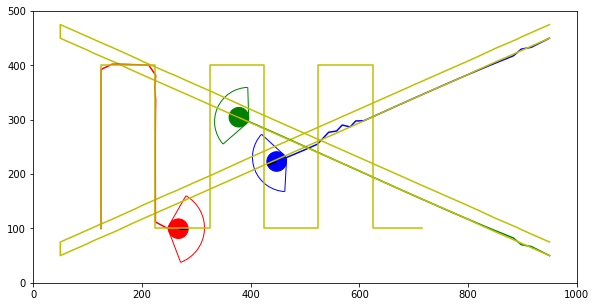

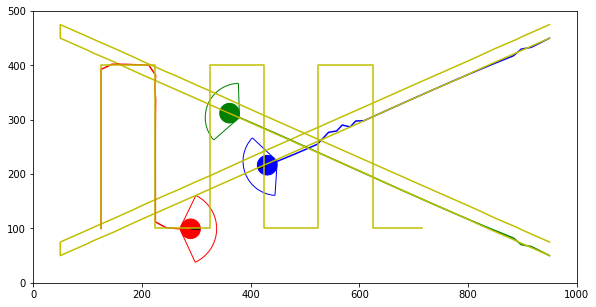

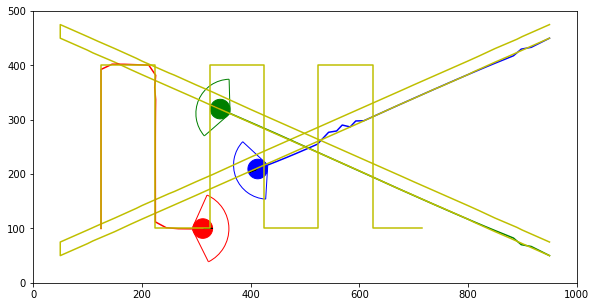

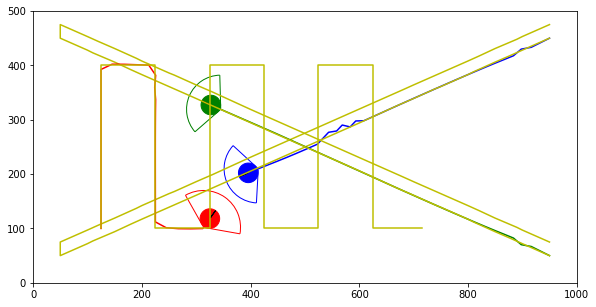

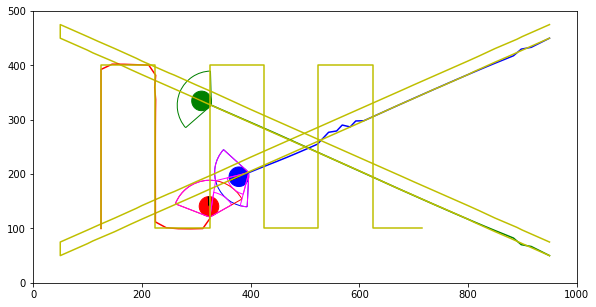

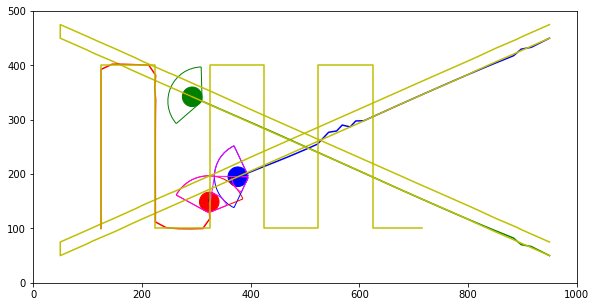

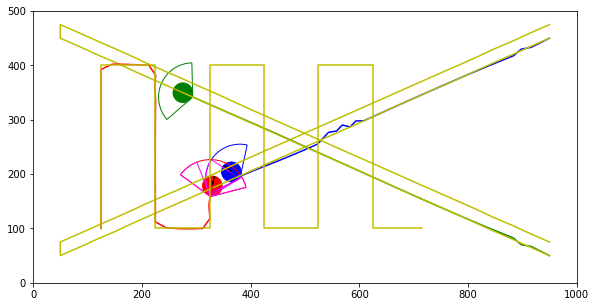

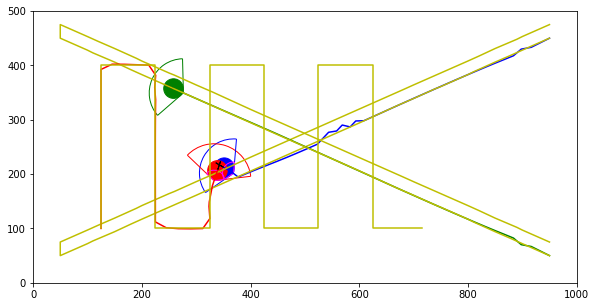

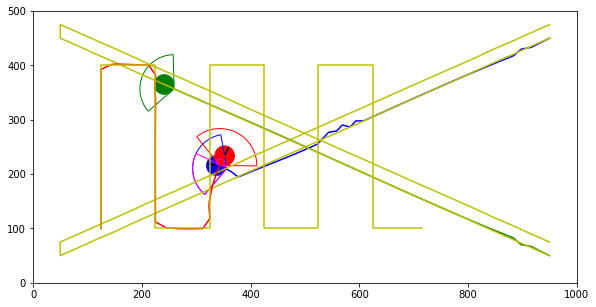

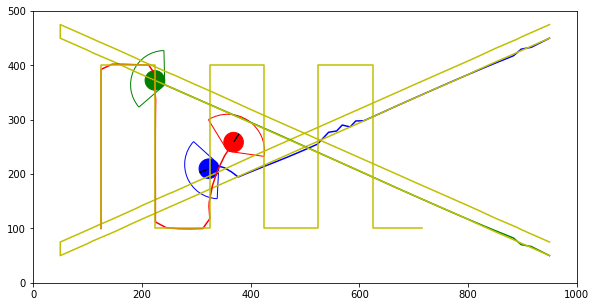

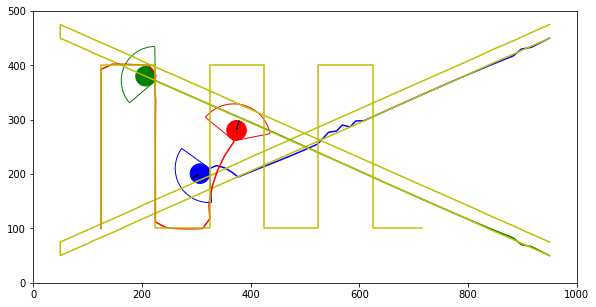

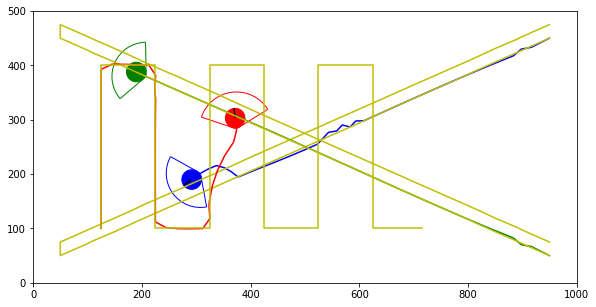

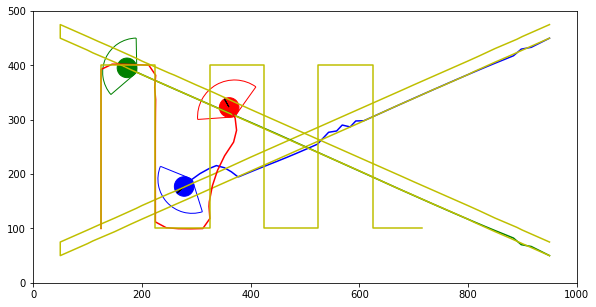

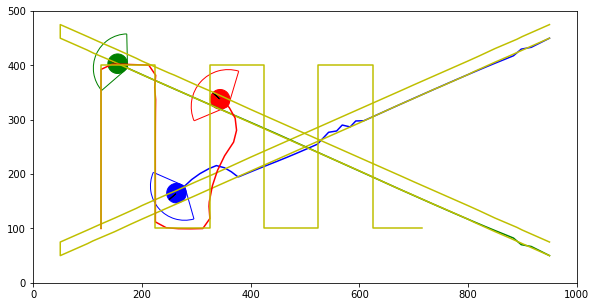

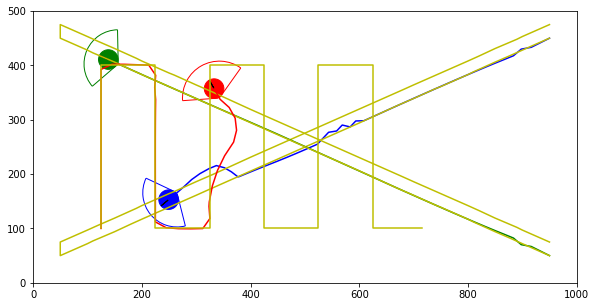

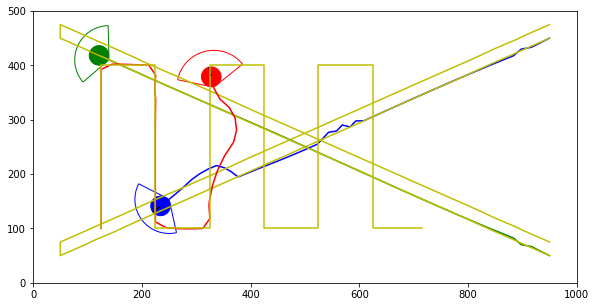

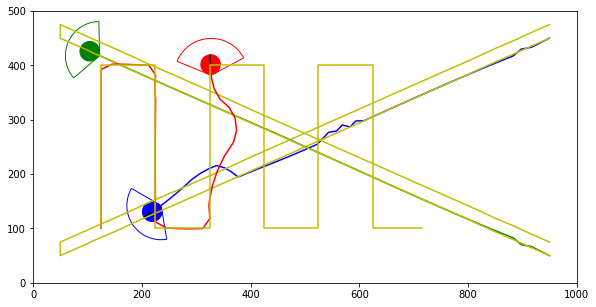

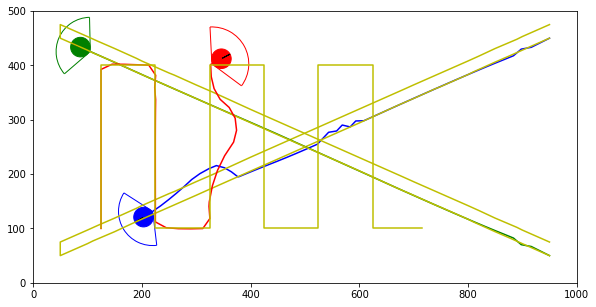

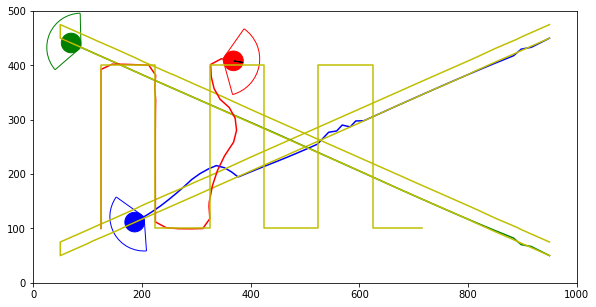

In [30]:
B = (50,50)
A = (950,450)
C = (950,50)
F = (950,75)
D = (50,450)
E = (50,475)
X = (50,75)
Y = (950,475)
#E = (400,1000)
AB = get_line(A,B,70,50)
BX = get_line(B,X,70,50)
XY = get_line(X,Y,70,50)

#BC = get_line(B,C)
CD = get_line(C,D,70,50)
DE = get_line(D,E,70,50)
EF = get_line(E,F,70,50)

path1 = np.concatenate((AB,BX,XY))
path2 = np.concatenate((CD,DE,EF))
#DE = get_line(D,E)
px = 25
P = (px+100,100)
lines = []
for i in range(1,6,2):
    
    Px = (px+100*i,100)
    Py = (px+100*i,400)
    Qx = (px+100*(i+1),400)
    Qy = (px+100*(i+1),100)
    Q1x = (px+100*(i+2),100)
    lines.append(get_line(Px,Py,50,35))
    lines.append(get_line(Py,Qx,30,30))
    lines.append(get_line(Qx,Qy,50,35))
    lines.append(get_line(Qy,Q1x,30,30))
    
boustrophedon = np.concatenate(lines) 
# fig,ax = plt.subplots(figsize=(12,6))
# ax. set_aspect('equal')
# ax.set_xlim([0, 1000])
# ax.set_ylim([0, 500])
# for point in boustrophedon:
#     ax.scatter(point[0],point[1],s=1,color='red')
#print(boustrophedon)


# full1 = np.concatenate((AB,BC),axis=0)
# full2 = np.concatenate((CD,DE),axis=0)
#robot = Robot(*(A),4.7,20,0,0.8,0)

#robot = Robot(626.4324691367921, 248.21824382060316, 6.842399164334139-2*np.pi,40,0,1.13,0)
#robot = Robot(600,600, 2*np.pi+1,35,0,1.13,0)
robot1 = Robot(*A,np.pi+np.arctan(0.5),25,0,1.13,0,path1)
robot2 = Robot(*C,np.pi-np.arctan(0.5),25,0,1.13,0,path2)
robot2.color = 'green'
robot3 = Robot(*(P),np.pi/2,30,0,1.13,0,boustrophedon)
robot3.color = 'red'
#robot = Robot(*(250,600),3.14,20,0,1,0)
robot1.fellows = [robot2,robot3]
robot2.fellows = [robot1,robot3]
robot3.fellows = [robot1,robot2]

log = []


for i in range(150):
    try:
        clear_output(wait = True)
        fig,ax = plt.subplots(figsize=(10,5))
        ax. set_aspect('equal')
        ax.set_xlim([0, 1000])
        ax.set_ylim([0, 500])
        #ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
        
        robot1.plot(ax)
        robot1.plot_interval(ax)
        robot2.plot(ax)
        robot2.plot_interval(ax)
        robot3.plot(ax)
        robot3.plot_interval(ax)
        
 
        Js1 = robot1.collision_detection() 
        Js2 = robot2.collision_detection() 
        Js3 = robot3.collision_detection()
        robot1 = robot1.next_bot(Js1,0,ax) 
        robot2 = robot2.next_bot(Js2,1,ax) 
        robot3 = robot3.next_bot(Js3,2,ax)
#         robot1 = robot1.next_pose(Js1,1,ax) 
#         robot2 = robot2.next_pose(Js2,0,ax) 
#         robot3 = robot3.next_pose(Js3,0,ax)


        plt.savefig(f'captures3/fig{i}.png',dpi=100)
        print("run : ",i+1)   
        if all([robot1.done,robot2.done,robot3.done]):
            print("stop")
            break
    except KeyboardInterrupt:
        try:
            break
        except GeometryError:
            break
#plt.show()            

In [77]:
import imageio
images = []
for i in range(95):
    filename = f'captures/fig{i}.png'
    #filename1 = f'captures2/fig{i}a.png'
    #print(filename)
    images.append(imageio.imread(filename))
    images.append(imageio.imread(filename))
imageio.mimsave('multi-1.gif', images)